# Introdução

# Dependências

In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tweepy
!{sys.executable} -m pip install requests

In [154]:
import pandas as pd
import pandas.api.types as ptypes
import numpy as np
import requests
import tweepy

import json
import os
%matplotlib inline

# Coleta

## Previsões

In [105]:
predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
filename = 'image_predictions.tsv'
if not os.path.exists(filename):
    response = requests.get(predictions_url)
    with open(filename, 'wb') as file:
        file.write(response.content)

In [106]:
df_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
df_predictions_clean = df_predictions.copy()

## Tweets

In [107]:
df_tweets = pd.read_csv('twitter-archive-enhanced.csv')
df_tweets_clean = df_tweets.copy()

## Contagem de retweets e favoritos

In [ ]:
consumer_key = os.environ['TWITTER_CONSUMER_KEY']
consumer_secret = os.environ['TWITTER_CONSUMER_SECRET']
access_token = os.environ['TWITTER_ACCESS_TOKEN']
access_token_secret = os.environ['TWITTER_ACCESS_TOKEN_SECRET']

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

twitter_api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# Função para mapear o resultado de cada chamada API para um resultado JSON
def get_retweet_counts(tweet_id):
    try:
        tweet_status = twitter_api.get_status(tweet_id, tweet_mode='extended')
        return tweet_status._json
    except tweepy.TweepError:
        pass

In [7]:
filename = 'tweet_json.txt'

if not os.path.exists(filename):
    tweet_counts = df_tweets_clean['tweet_id'].apply(lambda tweet_id: get_retweet_counts(tweet_id))
    with open(filename, 'w+') as handle:
        for tweet_count in tweet_counts:
            handle.write(json.dumps(tweet_count) + '\n')

tweet_data = []
with open(filename, 'r') as handle:
    for line in handle:
        tweet_count = json.loads(line)
        tweet_data.append(tweet_count)

In [108]:
filtered_tweet_data = list(filter(lambda r: r is not None, tweet_data))
df_tweet_data_from_api = pd.DataFrame(filtered_tweet_data)
df_tweet_counts_clean = df_tweet_data_from_api[['id', 'favorite_count', 'retweet_count']].copy()

# Fusão dos dados de tweet e contagem de retweet e favoritos

In [109]:
df_tweet_counts_clean = df_tweet_counts_clean.rename(columns={'id': 'tweet_id'})
df_tweets_clean = pd.merge(df_tweets_clean, df_tweet_counts_clean, how='left', on='tweet_id')

# Avaliação

## Estrutura do DataFrame de previsões

In [110]:
df_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Estrutura do DataFrame de tweets

In [111]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

## Identificação de Retweets

In [112]:
df_retweets = df_tweets_clean[df_tweets_clean.retweeted_status_user_id.notnull()]
df_retweets.shape[0]

181

## Denominador com valor abaixo de 10

In [113]:
df_denominator_below_10 = df_tweets_clean[df_tweets_clean.rating_denominator < 10]
df_denominator_below_10.shape[0]

3

## Denominador com valor acima de 10

In [114]:
df_denominator_above_10 = df_tweets_clean[df_tweets_clean.rating_denominator > 10]
df_denominator_above_10.shape[0]

20

## Tweets sem referência do nome do animal

In [115]:
df_no_name = df_tweets_clean[df_tweets_clean.name == 'None']
df_no_name.shape[0]

745

# Documentação dos Problemas de Qualidade

## Problemas de Qualidade

1. 181 tweets são retweets (seção "Identificação de Retweets")
2. Tipo das colunas "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id" deve ser alterado de float64 para int64 (seção "Estrutura do DataFrame de tweets")
3. Tipo das colunas "favorite_count" e "retweet_count" deve ser alterado de float64 para int64, após fusão dos dados (seção "Estrutura do DataFrame de tweets")
4. Tipo das colunas "timestamp" e "retweeted_status_timestamp" deve ser alterado de string (object) para datetime
5. 3 tweets com denominador abaixo de 10 (seção "Denominador com valor abaixo de 10")
6. 20 tweets com denominador acima de 10 (seção "Denominador com valor acima de 10")
7. 745 tweets não contém o nome do animal a qual se referem (seção "Tweets sem referência do nome do animal") (**Não pode ser limpo**)
8. Alguns tweets não possuem predições (**Não pode ser limpo**)

## Problemas de Arrumação

1. DataFrame com as previsões contem 9 colunas relacionadas aos valores de previsão, onde apenas 3 colunas devem ser utilizadas para normalizar estes valores (previsão, intervalo de confiança e valor booleano indicando se a previsão é uma raça de cachorro) (seção "Estrutura do DataFrame de previsões")
2. DataFrame com os tweets contem 4 colunas relacionadas ao "estágio" do animal, podendo ser normalizada para apenas uma coluna "estágio" (seção "Estrutura do DataFrame de tweets")

# Limpeza

## Problemas de Qualidade

### 1. Descartar retweets (não são o foco da análise)

In [116]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.retweeted_status_user_id.isnull()]
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
favorite_count                2171 non

#### Teste

In [117]:
assert len(df_tweets_clean[df_tweets_clean.retweeted_status_user_id.notnull()]) == 0

### 2. Ajustar tipo de dados das colunas "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id" e "retweeted_status_user_id" (float para int)

In [118]:
df_tweets_clean.in_reply_to_status_id = df_tweets_clean.in_reply_to_status_id.fillna(0).astype(int)
df_tweets_clean.in_reply_to_user_id = df_tweets_clean.in_reply_to_user_id.fillna(0).astype(int)
df_tweets_clean.retweeted_status_id = df_tweets_clean.retweeted_status_id.fillna(0).astype(int)
df_tweets_clean.retweeted_status_user_id = df_tweets_clean.retweeted_status_user_id.fillna(0).astype(int)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         2175 non-null int64
in_reply_to_user_id           2175 non-null int64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null int64
retweeted_status_user_id      2175 non-null int64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
favorite_count                2171 n

#### Teste

In [119]:
assert len(df_tweets_clean[df_tweets_clean.in_reply_to_status_id.isnull()]) == 0
assert len(df_tweets_clean[df_tweets_clean.in_reply_to_user_id.isnull()]) == 0
assert len(df_tweets_clean[df_tweets_clean.retweeted_status_id.isnull()]) == 0
assert len(df_tweets_clean[df_tweets_clean.retweeted_status_user_id.isnull()]) == 0

assert ptypes.is_integer_dtype(df_tweets_clean.in_reply_to_status_id)
assert ptypes.is_integer_dtype(df_tweets_clean.in_reply_to_user_id)
assert ptypes.is_integer_dtype(df_tweets_clean.retweeted_status_id)
assert ptypes.is_integer_dtype(df_tweets_clean.retweeted_status_user_id)

### 3. Ajustar tipo de dados das colunas "favorite_count" e "retweet_count" (float para int)

In [120]:
df_tweets_clean.favorite_count = df_tweets_clean.favorite_count.fillna(0).astype(int)
df_tweets_clean.retweet_count = df_tweets_clean.retweet_count.fillna(0).astype(int)

#### Teste

In [121]:
assert len(df_tweets_clean[df_tweets_clean.favorite_count.isnull()]) == 0
assert len(df_tweets_clean[df_tweets_clean.retweet_count.isnull()]) == 0

assert ptypes.is_integer_dtype(df_tweets_clean.favorite_count)
assert ptypes.is_integer_dtype(df_tweets_clean.retweet_count)

### 4. Ajustar tipo de dados das colunas "timestamp" e "retweeted_status_timestamp" (string para datetime)

In [122]:
df_tweets_clean.timestamp = pd.to_datetime(df_tweets_clean.timestamp)
df_tweets_clean.retweeted_status_timestamp = pd.to_datetime(df_tweets_clean.retweeted_status_timestamp)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         2175 non-null int64
in_reply_to_user_id           2175 non-null int64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null int64
retweeted_status_user_id      2175 non-null int64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
favorite_count      

#### Teste

In [123]:
assert ptypes.is_datetime64_any_dtype(df_tweets_clean.timestamp)
assert ptypes.is_datetime64_any_dtype(df_tweets_clean.retweeted_status_timestamp)

### 5. Ajustar tweets com denominador abaixo de 10

In [124]:
pd.set_option('display.max_colwidth', -1)

In [125]:
df_tweets_clean[df_tweets_clean.rating_denominator < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
313,835246439529840640,835245984028504064,26259576,2017-02-24 21:54:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0,0,NaT,NaN,960,0,None,None,None,None,None,2224,80
516,810984652412424192,0,0,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,0,0,NaT,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None,5788,1601
2335,666287406224695296,0,0,2015-11-16 16:11:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,0,0,NaT,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None,149,64


Existem 3 tweets com denominador abaixo de 10:
- 835246439529840640
- 810984652412424192
- 666287406224695296

Podemos utilizar os dados obtidos através da API do Twitter para avaliar as notas corretamente.

#### Tweet 835246439529840640

In [126]:
df_tweet_data_from_api[df_tweet_data_from_api.id == 835246439529840640]['full_text']

305    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: full_text, dtype: object

Este tweet foi uma resposta a dois outros usuários, onde o primeiro deu uma 13/10 e o segundo uma nota 960/00. Como não foi dada uma nota diretamente pelo usuário @WeRateDogs, podemos descartar este tweet como inválido.

In [127]:
idx = df_tweets_clean[df_tweets_clean.tweet_id == 835246439529840640].index
df_tweets_clean = df_tweets_clean.drop(idx)

#### Teste

In [128]:
assert len(df_tweets_clean[df_tweets_clean.rating_denominator < 10]) == 2

#### Tweet 810984652412424192

In [129]:
df_tweet_data_from_api[df_tweet_data_from_api.id == 810984652412424192]['full_text']

506    Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Name: full_text, dtype: object

Neste caso, o texto "24/7" foi interpretado incorretamente como a nota dada. Como não há uma nota definida no tweet para o animal, podemos descartá-lo.

In [130]:
idx = df_tweets_clean[df_tweets_clean.tweet_id == 810984652412424192].index
df_tweets_clean = df_tweets_clean.drop(idx)

#### Teste

In [131]:
assert len(df_tweets_clean[df_tweets_clean.rating_denominator < 10]) == 1

#### Tweet 666287406224695296

In [132]:
df_tweet_data_from_api[df_tweet_data_from_api.id == 666287406224695296]['full_text']

2319    This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Name: full_text, dtype: object

Conforme o texto obtido a partir da API, a nota correta é 9/10.

In [133]:
tweet_666287406224695296 = df_tweets_clean[df_tweets_clean.tweet_id == 666287406224695296].index

In [134]:
df_tweets_clean.loc[tweet_666287406224695296, 'rating_numerator'] = 9
df_tweets_clean.loc[tweet_666287406224695296, 'rating_denominator'] = 10

#### Teste

In [135]:
assert len(df_tweets_clean[df_tweets_clean.rating_denominator < 10]) == 0

In [136]:
pd.reset_option('display.max_colwidth')

### 6. Ajustar tweets com denominador acima de 10

In [137]:
def adjust_denominator_to_10(row):
    current_numerator = row['rating_numerator']
    current_denominator = row['rating_denominator']
    if current_denominator > 10:
        new_numerator = int(current_numerator * 10 / current_denominator)
        row['rating_numerator'] = new_numerator
        row['rating_denominator'] = 10
    return row

In [138]:
df_tweets_clean = df_tweets_clean.apply(adjust_denominator_to_10, axis=1)
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2173 non-null int64
in_reply_to_status_id         2173 non-null int64
in_reply_to_user_id           2173 non-null int64
timestamp                     2173 non-null datetime64[ns]
source                        2173 non-null object
text                          2173 non-null object
retweeted_status_id           2173 non-null int64
retweeted_status_user_id      2173 non-null int64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2116 non-null object
rating_numerator              2173 non-null int64
rating_denominator            2173 non-null int64
name                          2173 non-null object
doggo                         2173 non-null object
floofer                       2173 non-null object
pupper                        2173 non-null object
puppo                         2173 non-null object
favorite_count      

#### Teste

In [139]:
assert len(df_tweets_clean[df_tweets_clean.rating_denominator > 10]) == 0

### 7. 745 tweets não contém o nome do animal a qual se referem

In [140]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.name != 'None']

#### Teste

In [141]:
assert len(df_tweets_clean[df_tweets_clean.name == 'None']) == 0

### 8. Alguns tweets não tem predição

In [142]:
df_tweets_clean.shape[0]

1494

In [143]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.tweet_id.isin(df_predictions_clean.tweet_id)]

#### Teste

In [144]:
assert len(df_tweets_clean[~df_tweets_clean.tweet_id.isin(df_predictions_clean.tweet_id)]) == 0

## Problemas de Arrumação

### 1. Ajuste das predições - 3 colunas para predição, intervalo de confiança e variável booleana se predição é de um cachorro

In [145]:
df_predictions_1 = df_predictions_clean[["tweet_id", "jpg_url", "img_num", "p1", "p1_conf", "p1_dog"]].copy()
df_predictions_2 = df_predictions_clean[["tweet_id", "jpg_url", "img_num", "p2", "p2_conf", "p2_dog"]].copy()
df_predictions_3 = df_predictions_clean[["tweet_id", "jpg_url", "img_num", "p3", "p3_conf", "p3_dog"]].copy()

df_predictions_1.rename(columns={'p1': 'prediction', 'p1_conf': 'confidence_interval', 'p1_dog': 'is_dog_race'}, inplace=True)
df_predictions_2.rename(columns={'p2': 'prediction', 'p2_conf': 'confidence_interval', 'p2_dog': 'is_dog_race'}, inplace=True)
df_predictions_3.rename(columns={'p3': 'prediction', 'p3_conf': 'confidence_interval', 'p3_dog': 'is_dog_race'}, inplace=True)

df_predictions_clean = pd.concat([df_predictions_1, df_predictions_2, df_predictions_3])
df_predictions_clean.shape[0]

6225

#### Teste

In [146]:
assert set(['prediction','confidence_interval', 'is_dog_race']).issubset(df_predictions_clean.columns)

### 2. Ajuste dos tweets - nova coluna para "estágio" do animal

In [147]:
id_vars = set(df_tweets_clean.columns).difference(set(['pupper','puppo', 'floofer', 'doggo']))
df_tweets_clean = pd.melt(df_tweets_clean, id_vars=id_vars, var_name='phase', value_name='is_in_phase')

In [148]:
def change_to_bool(row):
    row['is_in_phase'] = (row['is_in_phase'] != 'None')
    return row

In [149]:
df_tweets_clean = df_tweets_clean.apply(change_to_bool, axis=1)

#### Teste

In [150]:
assert set(['phase','is_in_phase']).issubset(df_tweets_clean.columns)

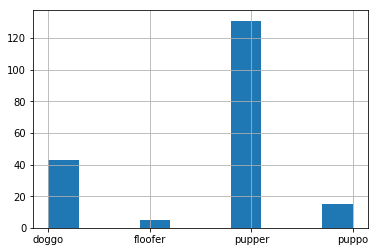

In [156]:
df_tweets_clean[df_tweets_clean.is_in_phase]['phase'].hist()

In [187]:
x = df_tweets_clean[~df_tweets_clean.name.str.islower()]

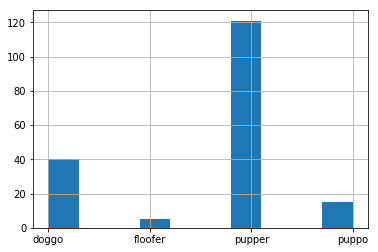

In [188]:
x[x.is_in_phase]['phase'].hist()

In [225]:
y = x[x.is_in_phase]['name'].value_counts().nlargest(5)

In [239]:
z = y.reset_index().rename(columns={'name': 'count', 'index':'name'})

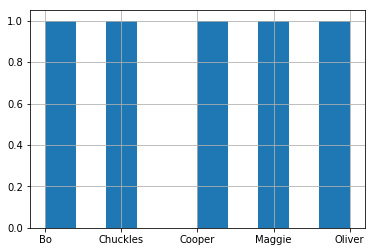

In [249]:
z['name'].hist()

In [243]:
import seaborn as sns

sns.distplot(data=z)

TypeError: distplot() got an unexpected keyword argument 'data'